# Cluster Module

The cluster module uses a set of coordinates and a cutoff distance to determine clustered points. The example below generates random points, and shows that they form clusters. This case is two-dimensional (with z=0 for all particles) for simplicity, but the cluster module works for both 2D and 3D simulations.

In [1]:
import numpy as np
import freud
import matplotlib.pyplot as plt

First, we generate random points to cluster.

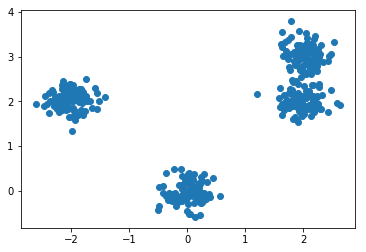

In [2]:
points = np.empty(shape=(0, 2))
for center_point in [(0, 0), (2, 2), (-2, 2), (2, 3)]:
    points = np.concatenate(
        (points, np.random.multivariate_normal(mean=center_point, cov=0.05*np.eye(2), size=(100,))))
plt.scatter(points[:,0], points[:,1])
plt.show()

# We must add a z=0 component to this array for freud
points = np.hstack((points, np.zeros((points.shape[0], 1))))

Now we create a box and a cluster compute object.

In [3]:
box = freud.box.Box.square(L=10)
cl = freud.cluster.Cluster(box=box, rcut=1.0)

Next, we use the `computeClusters` method to determine clusters and the `clusterIdx` property to return their identities. Note that we use `freud`'s *method chaining* here, where a compute method returns the compute object.

In [4]:
cluster_idx = cl.computeClusters(points).cluster_idx
print(cluster_idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


There are 100 points in cluster 0.
There are 200 points in cluster 1.
There are 100 points in cluster 2.


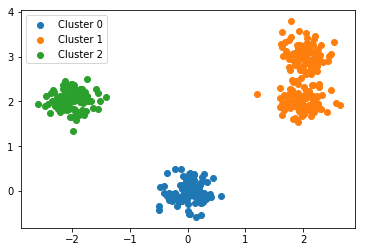

In [5]:
for cluster_id in range(cl.num_clusters):
    cluster_point_indices = np.where(cluster_idx == cluster_id)[0]
    plt.scatter(points[cluster_point_indices, 0], points[cluster_point_indices, 1], label="Cluster {}".format(cluster_id))
    print("There are {} points in cluster {}.".format(len(cluster_point_indices), cluster_id))
plt.legend(loc='best')
plt.show()